In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as td

import matplotlib.pyplot as plt
import seaborn as sns

Import relevant helper functions.
The utils file contains implementations of dataset-specific functions, and the estimators file implements several different estimators including:
- CPC and ML-CPC (aka InfoNCE)
- NWJ lower bound
- NWJ eval + JS train
- Donsker-Varadhan lower bound
- SMILE

In [2]:
from utils import *
from estimators import estimate_mutual_information

Next, we define the helper function for setting up the training procedure.

In [3]:
# define the dimension of the Gaussian

dim = 20

# define the training procedure

CRITICS = {
    'separable': SeparableCritic,
    'concat': ConcatCritic,
}

BASELINES = {
    'constant': lambda: None,
    'unnormalized': lambda: mlp(dim=dim, hidden_dim=512, output_dim=1, layers=2, activation='relu').cuda(),
    'gaussian': lambda: log_prob_gaussian,
}


def train_estimator(critic_params, data_params, mi_params, opt_params, **kwargs):
    """Main training loop that estimates time-varying MI."""
    # Ground truth rho is only used by conditional critic
    critic = CRITICS[mi_params.get('critic', 'separable')](
        rho=None, **critic_params).cuda()
    baseline = BASELINES[mi_params.get('baseline', 'constant')]()

    opt_crit = optim.Adam(critic.parameters(), lr=opt_params['learning_rate'])
    if isinstance(baseline, nn.Module):
        opt_base = optim.Adam(baseline.parameters(),
                              lr=opt_params['learning_rate'])
    else:
        opt_base = None

    def train_step(rho, data_params, mi_params):
        # Annoying special case:
        # For the true conditional, the critic depends on the true correlation rho,
        # so we rebuild the critic at each iteration.
        opt_crit.zero_grad()
        if isinstance(baseline, nn.Module):
            opt_base.zero_grad()

        if mi_params['critic'] == 'conditional':
            critic_ = CRITICS['conditional'](rho=rho).cuda()
        else:
            critic_ = critic

        x, y = sample_correlated_gaussian(
            dim=data_params['dim'], rho=rho, batch_size=data_params['batch_size'], cubic=data_params['cubic'])
        
        if mi_params.get('y_', None) is not None:
            _, y_ = sample_correlated_gaussian(
                dim=data_params['dim'], rho=rho, batch_size=data_params['batch_size'], cubic=data_params['cubic'])
        else:
            y_ = None

        kwargs['y_'] = y_
        mi = estimate_mutual_information(
            mi_params['estimator'], x, y, critic_, baseline_fn=baseline, alpha_logit=mi_params.get('alpha_logit', None), **kwargs)
        loss = -mi

        loss.backward()
        opt_crit.step()
        if isinstance(baseline, nn.Module):
            opt_base.step()

        return mi

    # Schedule of correlation over iterations
    mis = mi_schedule(opt_params['iterations'])
    rhos = mi_to_rho(data_params['dim'], mis)

    estimates = []
    for i in range(opt_params['iterations']):
        mi = train_step(rhos[i], data_params, mi_params)
        mi = mi.detach().cpu().numpy()
        estimates.append(mi)

    return np.array(estimates), critic

Parameters for the dataset, critic and optimization are listed below. For `cubic` results, set `'cubic': True` in `data_params`.

In [4]:
data_params = {
    'dim': dim,
    'batch_size': 128,
    'cubic': None
}

critic_params = {
    'dim': dim,
    'layers': 2,
    'embed_dim': 32,
    'hidden_dim': 256,
    'activation': 'relu',
}

opt_params = {
    'iterations': 20000,
    'learning_rate': 1e-3,
}

Perform training over the methods. Each method should take around 2 mins to run on a single GPU under the current experiment setting.

In [5]:
# Plotting helper functions.

def find_name(name):
    if 'smile_' in name:
        clip = name.split('_')[-1]
        return f'SMILE ($\\tau = {clip}$)'
    elif 'ml_infonce_' in name:
        alpha = name.split('_')[-1]
        return f'ML-CPC ($\\alpha = {alpha}$)'
    elif 'infonce_' in name:
        alpha = name.split('_')[-1]
        return f'CPC ($\\alpha = {alpha}$)'
    else:
        return {
            'infonce': 'CPC',
            'js': 'JS',
            'nwj': 'NWJ',
            'flow': 'GM (Flow)',
            'smile': 'SMILE ($\\tau = \\infty$)'
        }[name]

def find_legend(label):
    return {'concat': 'Joint critic', 'separable': 'Separable critic'}[label]

In [9]:

# Train for 20000 steps for each case.

mi_numpys = dict()

for critic_type in ['concat', 'separable']:
    mi_numpys[critic_type] = dict()
    for estimator in ['infonce', 'ml_infonce']:
        for alpha in [1.0, 0.1, 0.01, 0.001, 0.0001]:
            mi_params = dict(estimator=estimator, critic=critic_type, baseline='unnormalized')
            mis, critic = train_estimator(critic_params, data_params, mi_params, opt_params, alpha=alpha)
            mi_numpys[critic_type][f'{estimator}_{alpha}'] = mis


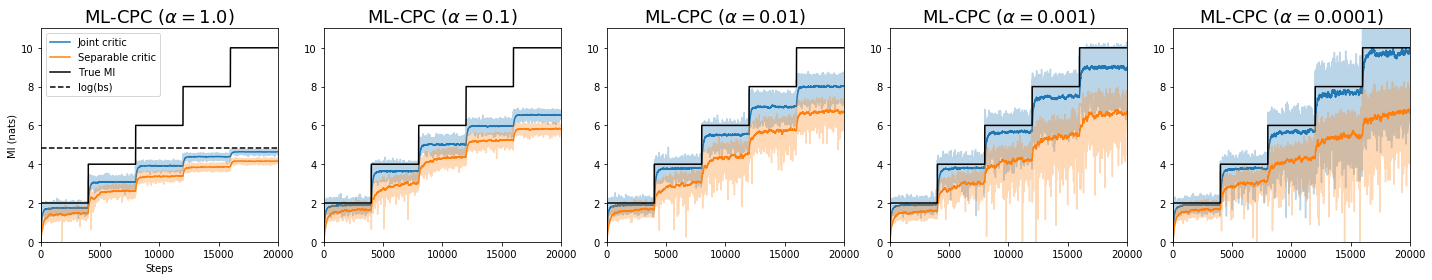

In [10]:
ncols = 5
nrows = 1
EMA_SPAN = 200
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])
estimator = 'ml_infonce'
for i, alpha in enumerate([1.0, 0.1, 0.01, 0.001, 0.0001]):
    key = f'{estimator}_{alpha}'
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=18)
    for net in ['concat', 'separable']:
        mis = mi_numpys[net][key]
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
    plt.ylim(0, 11)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color='k', label='True MI')
    if i == 0:
        plt.ylabel('MI (nats)')
        plt.xlabel('Steps')
        plt.axhline(np.log(128), color='k', ls='--', label='log(bs)')
        plt.legend()
        
plt.gcf().tight_layout()
plt.savefig('ml_infonce.pdf')

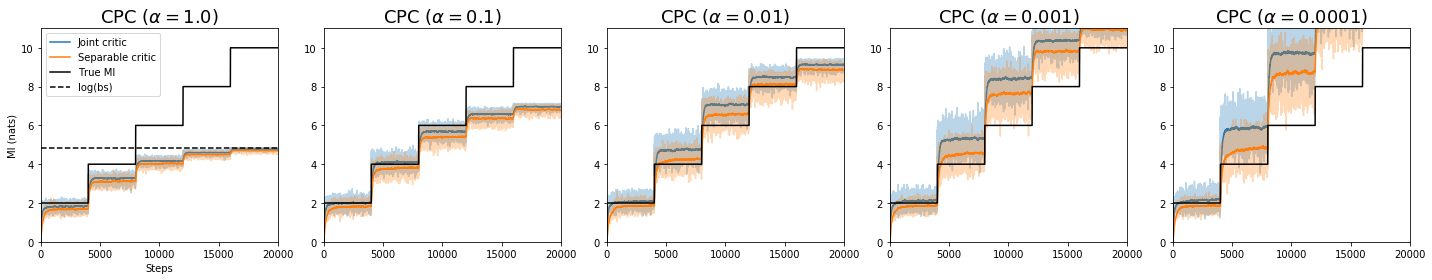

In [11]:
ncols = 5
nrows = 1
EMA_SPAN = 200
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])
estimator = 'infonce'
for i, alpha in enumerate([1.0, 0.1, 0.01, 0.001, 0.0001]):
    key = f'{estimator}_{alpha}'
    plt.sca(axs[i])
    plt.title(find_name(key), fontsize=18)
    for net in ['concat', 'separable']:
        mis = mi_numpys[net][key]
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label=find_legend(net))
    plt.ylim(0, 11)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color='k', label='True MI')
    if i == 0:
        plt.ylabel('MI (nats)')
        plt.xlabel('Steps')
        plt.axhline(np.log(128), color='k', ls='--', label='log(bs)')
        plt.legend()
        
plt.gcf().tight_layout()
plt.savefig('infonce.pdf')